In [1]:
import tensorflow as tf
import keras
import os, re, cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Conv2D, Dropout, MaxPool2D, Flatten, Dense, Activation, Conv2DTranspose, Concatenate, UpSampling2D, merge, Convolution2D, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy.ndimage.morphology import distance_transform_edt as edt
from IPython.display import clear_output
import datetime

In [2]:
%load_ext tensorboard

In [3]:
# Install a Drive FUSE wrapper.
 # https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse      

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144865 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [4]:
# Generate auth tokens for Colab

from google.colab import auth 
auth.authenticate_user()

In [5]:
# Generate creds for the Drive FUSE library.

from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default()
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass() 
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [6]:
# Create a directory and mount Google Drive using that directory.

!mkdir -p drive
!google-drive-ocamlfuse drive

In [7]:
imgs = np.load('drive/Brain_MRI_Data/brain_mri_images.npy')
labels = np.load('drive/Brain_MRI_Data/brain_mri_masks.npy')

In [51]:
def plotImages(images_arr, title):
    fig, axes = plt.subplots(1, 5, figsize=(20,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.squeeze(), cmap='Greys_r')
    plt.suptitle(title, y=0.7, fontsize=16)
    plt.tight_layout()
    plt.show()

In [9]:
x_train, test_imgs, y_train, test_labels = train_test_split(imgs, labels, test_size=0.2, random_state=0)

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [11]:
x_train.shape, x_val.shape, test_imgs.shape

((878, 256, 256, 1), (220, 256, 256, 1), (275, 256, 256, 1))

In [12]:
x_train /= 255.
y_train /= 255.
x_val /= 255.
y_val /= 255.
test_imgs /= 255.
test_labels /= 255.

In [13]:
x_labeled, x_unlabeled, y_labeled, y_unlabeled = train_test_split(x_train, y_train, test_size=0.625, random_state=0)

In [14]:
def call(self, inputs, training=None):
  if 0. < self.rate < 1.:
      noise_shape = self._get_noise_shape(inputs)
      def dropped_inputs():
          return K.dropout(inputs, self.rate, noise_shape,
                            seed=self.seed)
      if (training):
          return K.in_train_phase(dropped_inputs, inputs, training=training)
      else:
          return K.in_test_phase(dropped_inputs, inputs, training=None)
  return inputs

In [15]:
Dropout.call = call

In [16]:
def create_unet():
  input = Input(shape=(256,256,1))

  down1 = Conv2D(64, (3,3), padding='same')(input)
  down1 = Activation('relu')(down1)
  # down1 = Dropout(0.1)(down1)
  down1 = Conv2D(64, (3,3), padding='same')(down1)
  down1 = Activation('relu')(down1)

  down2 = MaxPool2D()(down1)
  down2 = Conv2D(128, (3,3), padding='same')(down2)
  down2 = Activation('relu')(down2)
  # down2 = Dropout(0.1)(down2)
  down2 = Conv2D(128, (3,3), padding='same')(down2)
  down2 = Activation('relu')(down2)

  down3 = MaxPool2D()(down2)
  down3 = Conv2D(256, (3,3), padding='same')(down3)
  down3 = Activation('relu')(down3)
  # down3 = Dropout(0.2)(down3)
  down3 = Conv2D(256, (3,3), padding='same')(down3)
  down3 = Activation('relu')(down3)

  down4 = MaxPool2D()(down3)
  down4 = Conv2D(512, (3,3), padding='same')(down4)
  down4 = Activation('relu')(down4)
  # down4 = Dropout(0.2)(down4)
  down4 = Conv2D(512, (3,3), padding='same')(down4)
  down4 = Activation('relu')(down4)

  down5 = MaxPool2D()(down4)
  down5 = Conv2D(1024, (3,3), padding='same')(down5)
  down5 = Activation('relu')(down5)
  
  down5 = Conv2D(1024, (3,3), padding='same')(down5)
  down5 = Activation('relu')(down5)

  down5 = Dropout(0.5)(down5)
  
  up1 = Conv2DTranspose(512, (2,2), strides=(2,2))(down5)
  up1 = Concatenate()([up1,down4])
  up1 = Conv2D(512, (3,3), padding='same')(up1)
  up1 = Activation('relu')(up1)
  # up1 = Dropout(0.2)(up1)
  up1 = Conv2D(512, (3,3), padding='same')(up1)
  up1 = Activation('relu')(up1)

  up2 = Conv2DTranspose(256, (2,2), strides=(2,2))(up1)
  up2 = Concatenate()([up2,down3])
  up2 = Conv2D(256, (3,3), padding='same')(up2)
  up2 = Activation('relu')(up2)
  # up2 = Dropout(0.2)(up2)
  up2 = Conv2D(256, (3,3), padding='same')(up2)
  up2 = Activation('relu')(up2)

  up3 = Conv2DTranspose(128, (2,2), strides=(2,2))(up2)
  up3 = Concatenate()([up3,down2])
  up3 = Conv2D(128, (3,3), padding='same')(up3)
  up3 = Activation('relu')(up3)
  # up3 = Dropout(0.1)(up3)
  up3 = Conv2D(128, (3,3), padding='same')(up3)
  up3 = Activation('relu')(up3)

  up4 = Conv2DTranspose(64, (2,2), strides=(2,2))(up3)
  up4 = Concatenate()([up4,down1])
  up4 = Conv2D(64, (3,3), padding='same')(up4)
  up4 = Activation('relu')(up4)
  # up4 = Dropout(0.1)(up4)
  up4 = Conv2D(64, (3,3), padding='same')(up4)
  up4 = Activation('relu')(up4)

  output = Conv2D(1, (1,1), activation='sigmoid')(up4)

  model =  Model(input, output)

  opt = Adam(learning_rate=1e-5)
  model.compile(optimizer=opt,loss=dice_coef_loss, metrics=[dice_coef])

  return model

In [17]:
def scheduler(epoch, lr):
  if epoch <= 2:
    return 1e-4
  else:
    return 1e-5

In [18]:
def dice_coef(y_true, y_pred, smooth=1.):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [19]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [20]:
def range_transform(sample):
  if (np.max(sample) == 1):
      sample = sample * 255

  m = 255 / (np.max(sample) - np.min(sample))
  n = 255 - m * np.max(sample)
  return (m * sample + n) / 255

In [21]:
def no_detections_index(uncertainity, nb_no_detections=10):
  return np.argsort(uncertainity)[0:nb_no_detections]

In [22]:
def most_uncertain_index(uncertainity, nb_most_unceratin=10):
  s_uncertainity = np.argsort(uncertainity)
  return s_uncertainity[::-1][0:nb_most_unceratin]

In [23]:
def interval(data, start, end):
  p = np.where(data >= start)[0]
  return p[np.where(data[p] < end)[0]]

In [24]:
def compute_uncertainity(x_unlabeled, best_model):
  
  uncertainity = []
  uncertainity_map = []
  i = 1
  n = len(x_unlabeled)
  for sample in x_unlabeled:
    sample = sample.reshape([1,256,256,1])
    all_step_predictions = np.zeros([256,256,1])
    for t in range(10):
      step_prediction = best_model.predict(sample).reshape([256,256,1])
      all_step_predictions = np.concatenate((all_step_predictions, step_prediction), axis=2)
    all_step_predictions = np.delete(all_step_predictions, [0], 2)
    var = np.var(all_step_predictions, axis=2)
    uncertainity_map.append(var.reshape(256,256,1))
    uncertain = np.sum(var)
    uncertainity.append(uncertain)

    clear_output(wait=True)
    print("Computing Uncertainty" + "."*((i%3)+1))
    print(str(i) + '/' + str(n) + ' images.')
    i = i+1

  return np.array(uncertainity), np.array(uncertainity_map)

In [25]:
def train(x_labeled, y_labeled, model, tensorboard_callback, epochs):
  
  checkpoint = ModelCheckpoint("initial_weights.h5", monitor='val_dice_coef', verbose=1, save_best_only=True, save_weights_only=True, mode='max', save_freq='epoch')
  early = EarlyStopping(monitor='val_dice_coef', min_delta=0.01, patience=10, verbose=1, mode='max')
  # scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

  results = model.fit(x_labeled, y_labeled, epochs = epochs, batch_size=16, validation_data=(x_val, y_val), callbacks=[early,checkpoint,tensorboard_callback])

In [26]:
def label_data(x_labeled, x_unlabeled, y_labeled, y_unlabeled, iteration):

  best_model = create_unet()
  best_model.load_weights('initial_weights.h5')
  predictions = best_model.predict(x_unlabeled)

  uncertainity, uncertainity_map = compute_uncertainity(x_unlabeled, best_model)

  histo = np.histogram(uncertainity, 100)

  # Oracle Indices
  not_detected = no_detections_index(uncertainity)
  most_uncertain = most_uncertain_index(uncertainity)

  oracle_i = interval(uncertainity, histo[1][np.argmax(histo[0]) + 6], histo[1][len(histo[0]) - 33])
  np.random.shuffle(oracle_i)
  random_index = oracle_i[:15]

  oracle_indices = np.concatenate((random_index, not_detected, most_uncertain))

  # Pseudo Indices
  nb_pseudo_indices = 20 * iteration
  pseudo_indices = interval(uncertainity, histo[1][np.argmax(histo[0])], histo[1][np.argmax(histo[0])+1])[:nb_pseudo_indices]

  # Update Labeled Data
  x_labeled = np.concatenate((x_labeled, x_unlabeled[pseudo_indices], x_unlabeled[oracle_indices]))
  x_unlabeled = np.delete(x_unlabeled, pseudo_indices, 0)
  x_unlabeled = np.delete(x_unlabeled, oracle_indices, 0)

  y_labeled = np.concatenate((y_labeled, predictions[pseudo_indices], y_unlabeled[oracle_indices]))
  y_unlabeled = np.delete(y_unlabeled, pseudo_indices, 0)
  y_unlabeled = np.delete(y_unlabeled, oracle_indices, 0)

  return x_labeled, x_unlabeled, y_labeled, y_unlabeled, uncertainity_map

In [27]:
def compute_dice_coef(y_true, y_pred):
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, 256 * 256])
    y_pred_f = y_pred.reshape([1, 256 * 256])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# **Initial Training**

In [30]:
log_dir="logs/BrainMRIInititial/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [31]:
model = create_unet()
train(x_labeled, y_labeled, model, tensorboard_callback, epochs=20)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 0.9444 - dice_coef: 0.0558WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0058s vs `on_test_batch_end` time: 0.2092s). Check your callbacks.

Epoch 00001: val_dice_coef improved from -inf to 0.05531, saving model to initial_weights.h5
21/21 [==============================] - 20s 941ms/step - loss: 0.9444 - dice_coef: 0.0558 - val_loss: 0.9444 - val_dice_coef: 0.0553
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.9441 - dice_coef: 0.0556
Epoch 00002: val_dice_coef improved from 0.05531 to 0.05552, saving model to initial_weights.h5
21/21 [==============================] - 20s 942ms/step - loss: 0.9441 - dice_coef: 0.0556 - val_loss: 0.9442 - val_dice_coef: 0.0555
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.9439 - dice_coef: 0.0559
Epoch 00003: val_dice_coef improved from 0.05552 to 0.05576, saving model to initial_

# **Active Learning**

In [32]:
# best_model = create_unet()
# best_model.load_weights('initial_weights.h5')
# predict = best_model.predict(x_unlabeled, verbose=1)

In [33]:
# unc, unc_map = compute_uncertainity(x_unlabeled, best_model)

In [34]:
# plt.hist(unc, 100)

In [35]:
uncertainity_maps = []
for i in range(5):

  x_labeled, x_unlabeled, y_labeled, y_unlabeled, uncertainity_map = label_data(x_labeled, x_unlabeled, y_labeled, y_unlabeled, i+1)
  uncertainity_maps.append(uncertainity_map)

  model = create_unet()
  model.load_weights('initial_weights.h5')

  log_dir="logs/BainMRIactive_iteration_" + str(i+1) + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

  train(x_labeled, y_labeled, model, tensorboard_callback, epochs=5)

Computing Uncertainty...
317/317 images.
Epoch 1/5
40/40 [==============================] - ETA: 0s - loss: 0.4301 - dice_coef: 0.5702WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0060s vs `on_test_batch_end` time: 0.2110s). Check your callbacks.

Epoch 00001: val_dice_coef improved from -inf to 0.55615, saving model to initial_weights.h5
40/40 [==============================] - 36s 909ms/step - loss: 0.4301 - dice_coef: 0.5702 - val_loss: 0.4429 - val_dice_coef: 0.5561
Epoch 2/5
40/40 [==============================] - ETA: 0s - loss: 0.3976 - dice_coef: 0.6029
Epoch 00002: val_dice_coef improved from 0.55615 to 0.55934, saving model to initial_weights.h5
40/40 [==============================] - 33s 824ms/step - loss: 0.3976 - dice_coef: 0.6029 - val_loss: 0.4395 - val_dice_coef: 0.5593
Epoch 3/5
40/40 [==============================] - ETA: 0s - loss: 0.3847 - dice_coef: 0.6159
Epoch 00003: val_dice_coef did not improve from

In [49]:
!tensorboard dev upload --logdir ./logs \
  --name "Active Learning for LGG Segmentation" \
  --description "Training results from https://colab.research.google.com/drive/1K6dR69CF_NqXinbkcSW87YvxGARpDGT3?usp=sharing" \
  --one_shot

2020-12-08 07:39:30.905973: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Upload started and will continue reading any new data as it's added
to the logdir. To stop uploading, press Ctrl-C.

View your TensorBoard live at: https://tensorboard.dev/experiment/u80HdQr1Tw6UWevJoPd2uQ/

[2020-12-08T07:39:32] Uploader started.
[2020-12-08T07:39:49] Total uploaded: 180 scalars, 2077 tensors (3.7 MB), 6 binary objects (1.5 MB)
Listening for new data in logdir...
Done. View your TensorBoard at https://tensorboard.dev/experiment/u80HdQr1Tw6UWevJoPd2uQ/


In [39]:
best_model = create_unet()
best_model.load_weights('initial_weights.h5')

In [40]:
predict = best_model.predict(test_imgs, verbose=1)

9/9 [==============================] - 7s 730ms/step


In [41]:
val_predict = best_model.predict(x_val, verbose=1)

7/7 [==============================] - 7s 966ms/step


In [77]:
test_dice = [compute_dice_coef(test_labels[x],predict[x]) for x in range(len(predict))]

In [43]:
val_dice = [compute_dice_coef(y_val[x],val_predict[x]) for x in range(len(val_predict))]

In [44]:
np.average(test_dice), np.median(test_dice), np.min(test_dice), np.max(test_dice)

(0.47232156939400655,
 0.5136389212318517,
 0.000296891653200902,
 0.925217130409723)

In [45]:
np.average(val_dice)

0.4823093192402679

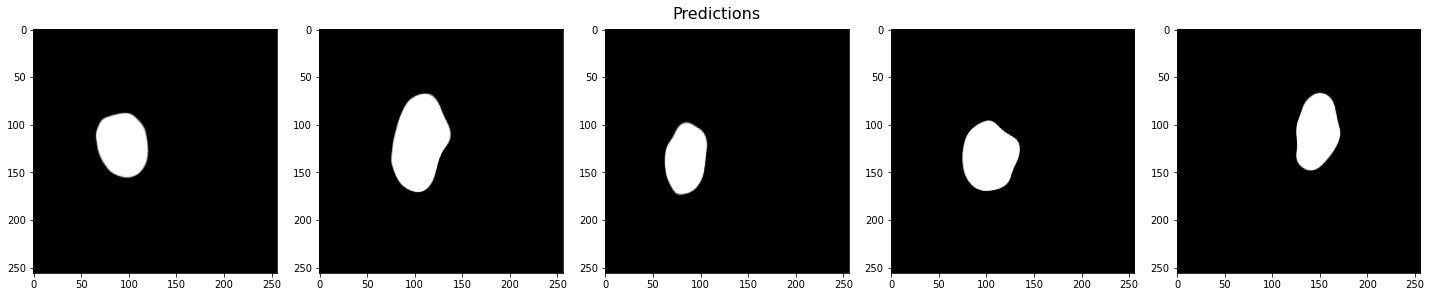

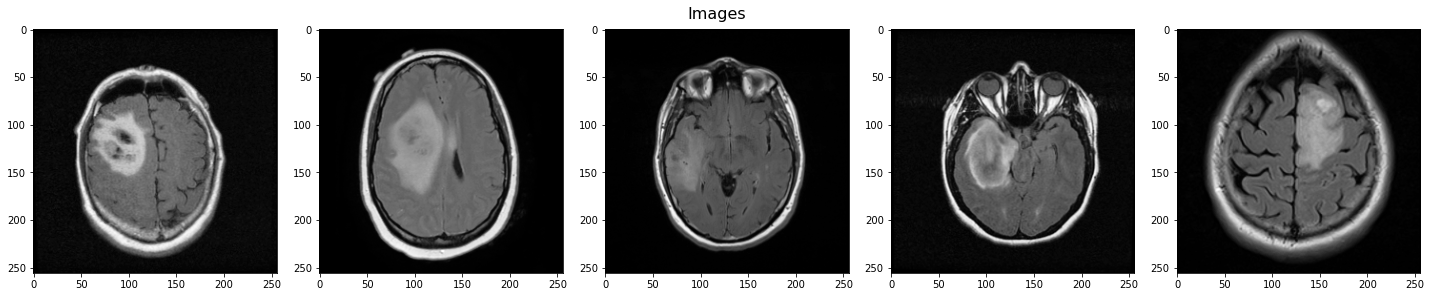

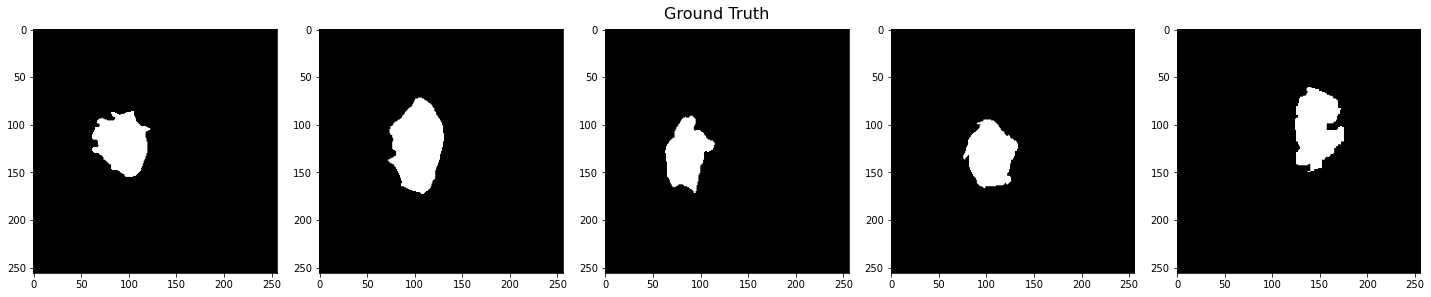

In [52]:
plotImages(predict[np.argsort(test_dice)[::-1]], 'Predictions')
plotImages(test_imgs[np.argsort(test_dice)[::-1]], 'Images')
plotImages(test_labels[np.argsort(test_dice)[::-1]], 'Ground Truth')

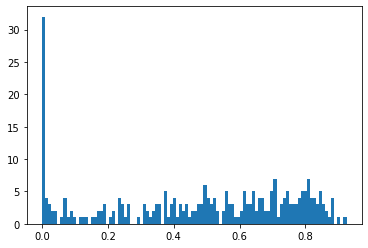

In [47]:
n, bins, patches = plt.hist(test_dice, 100)

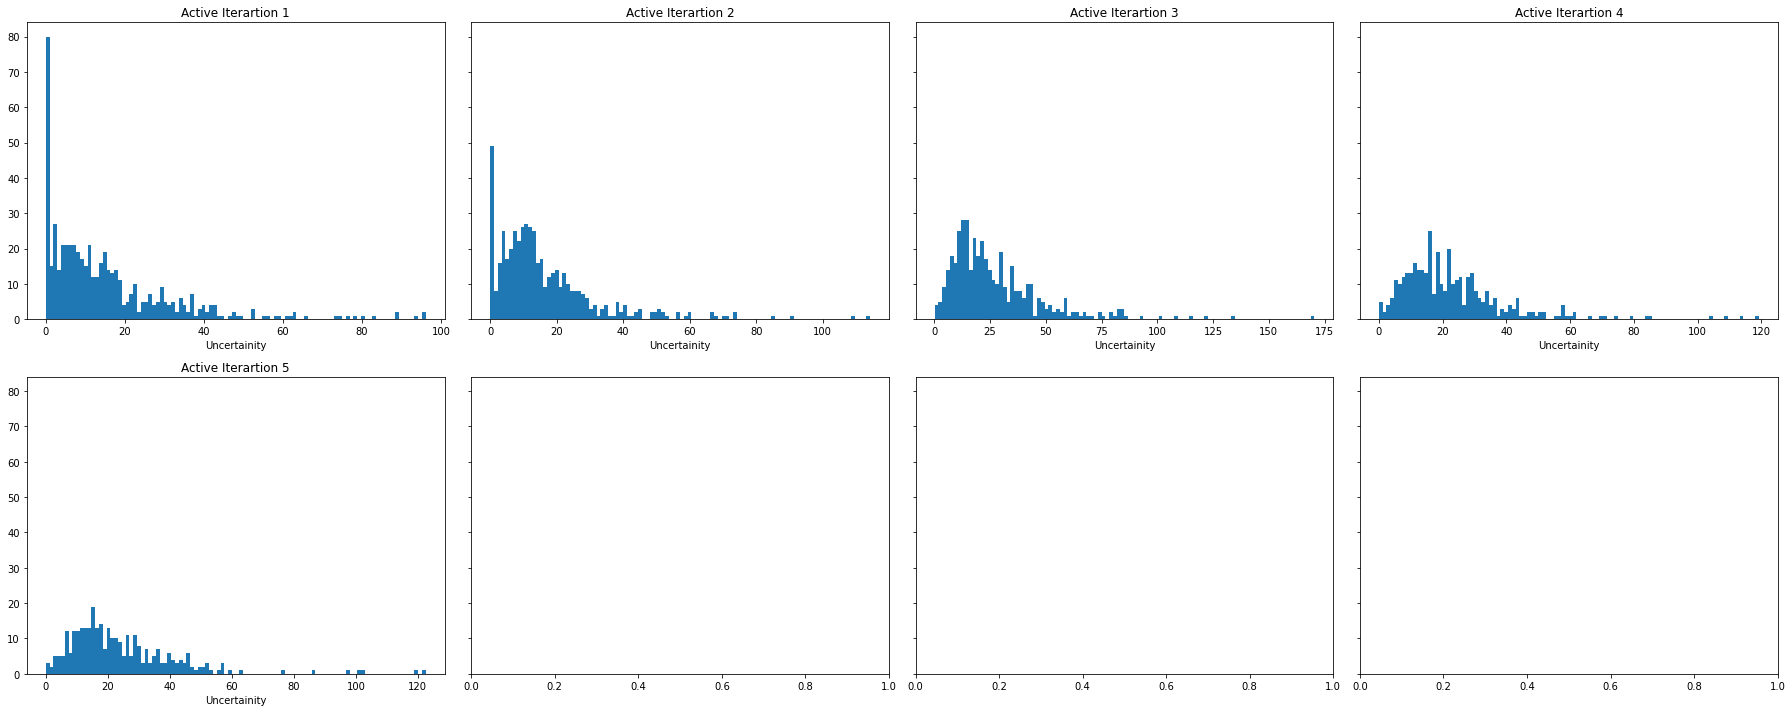

In [55]:
fig, ax = plt.subplots(2,4, sharey=True, tight_layout=True, figsize=(25,10))
axes = ax.flatten()
for i in range(len(uncertainity_maps)):
  n, bins, patches = axes[i].hist(np.sum(uncertainity_maps[i], axis=(1,2,3)), 100)
  axes[i].set_xlabel('Uncertainity')
  axes[i].set_title('Active Iterartion '+str(i+1))
plt.show()

In [75]:
best_model = create_unet()
best_model.load_weights('initial_weights.h5')

In [76]:
predict = best_model.predict(test_imgs)

In [59]:
u, m = compute_uncertainity(predict[:2], best_model)

Computing Uncertainty...
2/2 images.


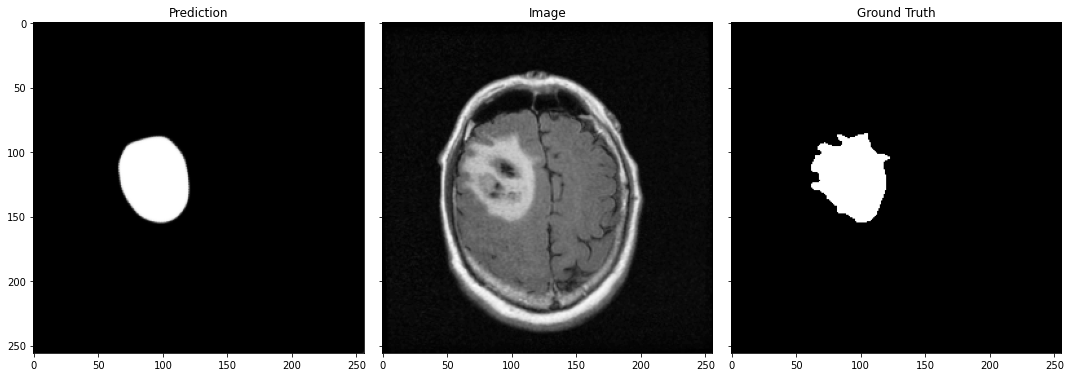

In [80]:
fig, ax = plt.subplots(1,3, sharey=True, tight_layout=True, figsize=(15,15))
axes = ax.flatten()
axes[0].imshow(predict[np.argsort(test_dice)[-1]].squeeze(), cmap='Greys_r')
axes[0].set_title('Prediction')
axes[1].imshow(test_imgs[np.argsort(test_dice)[-1]].squeeze(), cmap='Greys_r')
axes[1].set_title('Image')
axes[2].imshow(test_labels[np.argsort(test_dice)[-1]].squeeze(), cmap='Greys_r')
axes[2].set_title('Ground Truth')
plt.show()